## CSC 580 AI II (Winter 2026) **HW\#4 Atari Pong** -- Start-up code
### **Pong_train.ipynb** -- Perform further training

In [ ]:
## Code piece to mount my Google Drive
from google.colab import drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Mounted at /content/drive


In [ ]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive/CSC580_Winter2026/Atari_Pong'
os.chdir(thisdir)

# Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive/CSC580_Winter2026/Atari_Pong


## Install relevant libraries

In [ ]:
%pip install -r requirements.txt

In [ ]:
import dqn_core # dqn_core.py
from dqn_core import AtariPreprocess, FrameStack, PongActionReducer, ReplayBuffer, DQN, make_env
import gymnasium as gym
import numpy as np
import random
import pickle

## Create an ale  (for display)

In [ ]:
from ale_py import ALEInterface
ale = ALEInterface()

## 1. Create a DQN model (prediction/q_network and target_network) and load the pre-trained weights.  Also create the replay buffer and load the saved transitions.

Assume the q_net weight file is called **"q_net_XXXX.pt"** (where XXXX is the number of training steps, e.g. '700k' and '1M'), and it is found under the folder "checkpoints".  Note that this code is the same as the one in the evaluation code.

### Functions to load pretrained weights and replay buffer

In [ ]:
def build_networks(n_actions, device):
    """Build the prediction and target networks."""
    q_net = DQN(n_actions).to(device)      # prediction network
    target_net = DQN(n_actions).to(device) # (frozen) target network
    return q_net, target_net

def load_pretrained(q_net, target_net, q_file, t_file, device):
    """Load pretrained weights from files for q_net and target_net.
       Move the tensors to device when loading."""
    q_net.load_state_dict(torch.load(q_file, map_location=device))
    target_net.load_state_dict(torch.load(t_file, map_location=device))
    target_net.eval() # target network does not 'learn'
    print(f"✅ Loaded pretrained networks from checkpoints")

def load_replay_buffer(pklfilepath):
    """Load replay buffer.  Assuming a .pkl file."""
    replay = ReplayBuffer.load(pklfilepath)
    #with open(pklfilepath, "rb") as f:
    #    replay = pickle.load(f)
    print(f"✅ Loaded replay buffer with {len(replay)} transitions")
    return replay


### **Initial** calls to those functions to load models and reply buffer.  Also create an environment.

In [ ]:
import torch # define GPU access
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# folder and filenames for pretrained weights and reply buffer
checkpoint_dir = "checkpoints"

# (*) Initial checkpoint info
START_STEP = 700_000
str_steps = "_700k"

qnet_file = f"{checkpoint_dir}/q_net{str_steps}.pt"
target_file = f"{checkpoint_dir}/target_net{str_steps}.pt"
replay_file = f"{checkpoint_dir}/replay{str_steps}.pkl"

#------------------------------
# create an environment
env = make_env() # default env; function in dqn_core.py
n_actions = env.action_space.n
print(f"✅ Number of actions: {n_actions}")

# load pretrained model weights
q_net, target_net = build_networks(n_actions, DEVICE)
load_pretrained(q_net, target_net, qnet_file, target_file, DEVICE)

# Define optimizer here, after q_net is instantiated
import torch # Ensure torch is imported if not already
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4)

# Load the pre-loaded replay buffer
buffer = load_replay_buffer(replay_file)

✅ Number of actions: 4
✅ Loaded pretrained networks from checkpoints
✅ Loaded replay buffer with 100000 transitions


## 2. Further training
### 2.0 Declare global constants

In [ ]:
import torch.optim as optim

# Hyperparameters (students may tune)
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 100_000
LEARNING_RATE = 1e-4
TARGET_UPDATE_FREQ = 10_000
LEARNING_STARTS = 50_000
TOTAL_STEPS = 300_000

EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 1_500_000  # divisor to the current steps (e.g. 700,000 / 1,500,000 = 0.467)

### 2.1 select_action -- Epsilon-greedy strategy

In [ ]:
def select_action(state, current_steps):
    ## (*) TODO:
    ## Implement epsilon-greedy exploration.  It computes the epsilon as
    ## current steps divided by EPS_DECAY subtracted from EPS_START, or
    ## EPS_END, whichever the largest.
    ## Hint: Look at the evaluation section for the code for greedy choice.
    ##



### 2.2 Optimization (and backprop) step

In [ ]:
import torch.nn.functional as F

def optimize():
    if len(buffer) < BATCH_SIZE:
        return

    ## (*) TODO
    ## Obtain BATCH_SIZE number of transitions from the reply buffer.
    ## states, actions, rewards, next_states, dones = ...
    ##

    states = torch.tensor(states, device=DEVICE)
    actions = torch.tensor(actions, device=DEVICE).unsqueeze(1)
    rewards = torch.tensor(rewards, device=DEVICE)
    next_states = torch.tensor(next_states, device=DEVICE)
    # Convert dones to float32
    dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE)

    # Q(s, a): From the Q-network’s output, pick the Q-value corresponding
    # to the action that was actually taken, for each state in the batch.
    # 'q_net(states)' where states is of shape (B, 4, 84, 84), returns
    # q-values of the form '[[ 1.2, -0.4,  0.7,  3.5], [ 0.1,  0.9, -0.2,  0.4],..'
    # 'gather(1,actions)' returns [[3.5], [0.9],..], and squeeze(1) makes
    # into a 1-D array [3.5, 0.9,..]
    q_values = q_net(states).gather(1, actions).squeeze(1)

    # max_a' Q_target(s', a')
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        ## (*) TODO
        ## Compute the target values (based on the algorithm).
        ## target = ...
        ##

    # compute the loss
    loss = F.smooth_l1_loss(q_values, target)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## 3. Main Training Loop

In [ ]:
def do_train(start_step):
    episode_reward = 0

    obs, info = env.reset()
    # FIRE to start Pong
    obs, _, _, _, _ = env.step(1)

    for step in range(start_step + 1, start_step + TOTAL_STEPS):
        if step%1000 == 0:
          print (f"Step {step}")

        ## (*) TODO
        ## Select action based on the epsilon-greedy policy.
        ## action = ...

        # take the action
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        ## (*) TODO:
        ## Store transition in replay buffer
        ##

        obs = next_obs
        episode_reward += reward

        #if step > LEARNING_STARTS:
        optimize()

        ## (*) TODO
        ## Periodically update target network (TARGET_UPDATE_FREQ).
        ##
        ##
        ##

        if done:
            print(f"Step {step}: episode reward = {episode_reward}")
            obs, info = env.reset()
            # FIRE to start Pong
            obs, _, _, _, _ = env.step(1)
            episode_reward = 0

    return

## 3.1 **Run do_train()** by executing the cell below.

In [ ]:
# Train further TOTAL_STEPS number of steps
do_train(START_STEP)

## 4. Visualize the further-trained model (one episode)

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import time

def visualize_one_episode(model, env):
    obs, info = env.reset()
    obs, _, _, _, _ = env.step(1)  # FIRE to start the game

    # set up the visualization variables (fig, img, ax)
    fig, ax = plt.subplots(figsize=(4, 4))
    img = ax.imshow(env.render())
    ax.axis("off")

    display_handle = display(fig, display_id=True) # set up display_handle

    frames = [] # collect frames for a video

    # (*) start an episode (until either player reaches 21 points)
    # actions were chosen by the greedy strategy, selecting the action with the
    # largest value produced on the output layer of the model (q_net).
    done = False
    total_reward = 0

    while not done:
        with torch.no_grad():
            # tranform obs (4, 84, 84) to a batch (of one instance)
            state = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)

            # (*) select action with the highest Q-value for the current state.
            action = model(state).argmax(1).item()
            # q_net(state) returns model output, which is a tensor containing
            # values of the actions, e.g. 'tensor([[ 1.2, -0.4,  0.7,  3.5]])',
            # where the inner list is the average rewards of the actions.
            # Then .argmax(1) returns 'tensor([3])', then by .item(), we get 3,
            # the action number of the 'best' action.

        # take the action and receive info from the environment
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # visualization
        frame = env.render()
        frames.append
        img.set_data(frame)
        display_handle.update(fig)

        time.sleep(0.03)

    plt.close(fig)
    env.close()

    print("Total reward:", total_reward)
    return frames, total_reward


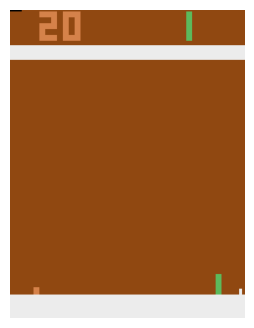

Total reward: -20.0


In [ ]:
# Call the visualization function (with the last model/q_net)
env = make_env(render_mode="rgb_array") # for visual rendering

model = DQN(n_actions)
model.load_state_dict(q_net.state_dict())
model.eval()

frames, total_reward = visualize_one_episode(q_net, env)

## 5. Save the model (q_net and target_net) and the replay buffer

In [ ]:
steps = "_1M"
qnet_file = f"{checkpoint_dir}/q_net{steps}.pt"
target_file = f"{checkpoint_dir}/target_net{steps}.pt"
replay_file = f"{checkpoint_dir}/replay{steps}.pkl"

torch.save(q_net.state_dict(), qnet_file)
torch.save(target_net.state_dict(), target_file)
buffer.save(replay_file)

env.close()

## 6. Create a video and save it

In [ ]:
import imageio

video_dir = "videos"
video_path = f"{video_dir}/pong{steps}.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"Saved video to {video_path}")


Saved video to videos/pong_1M.mp4
